In [ ]:
!gdown --id '1zi-pRMRhxrcZVBzb0ir406oJX9D7M-bn&confirm=true'

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zi-pRMRhxrcZVBzb0ir406oJX9D7M-bn&confirm=true
To: /content/saudi_validation.zip
100% 249M/249M [00:02<00:00, 92.0MB/s]


In [ ]:
!unzip -qq saudi_validation.zip

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
#@title Mask R-CNN
from __future__ import division, print_function, absolute_import
import os
import sys
import cv2
import numpy as np
import random
import torchvision
from torchvision.transforms import transforms as transforms
from torchvision.transforms import functional as F
import torch.nn as nn
import torch
from torchvision import transforms
from torchvision.transforms.functional import resize, normalize
from PIL import Image

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation = inter)
    return resized
    
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))


def fixed_crop(img):
    H,W,C =img.shape
    y=0
    x=0
    h=H//2
    w=int(W*25/100)
    cropA = img[y:y+h, x:x+w]
    y=0
    x=int(80*W/100)
    h=H//2
    w=w
    cropB = img[y:y+h, x:x+w]
    s1 = iswhite(cropA)
    s2 = iswhite(cropB)
    if s1 == False and s2 == False:
       return False
    else:
       return True


class Mask_RCNN():
    def __init__(self, extract_features=None, threshold = 0.97):
        self.threshold = threshold # 0.965
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])
        self.extract_features = extract_features
        # initialize the model
        self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True, 
                                                                  num_classes=91)
        # set the computation device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # load the modle on to the computation device and set to eval mode
        self.model.to(self.device ).eval()

    def get_outputs(self, image, threshold):
        with torch.no_grad():
            # forward pass of the image through the modle
            outputs = self.model(image)

        # get all the scores
        scores = list(outputs[0]['scores'].detach().cpu().numpy())
        # index of those scores which are above a certain threshold
        thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
        thresholded_preds_count = len(thresholded_preds_inidices)
        # get the masks
        masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
        # discard masks for objects which are below threshold
        masks = masks[:thresholded_preds_count]
        # get the bounding boxes, in (x1, y1), (x2, y2) format
        boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
        # discard bounding boxes below threshold value
        boxes = boxes[:thresholded_preds_count]
        # get the classes labels
        labels = [coco_names[i] for i in outputs[0]['labels']]
        return masks, boxes, labels



    def predict(self, frame):
        frame = self.transform(frame)
        # add a batch dimension
        frame = frame.unsqueeze(0).to(self.device )
        return self.get_outputs(frame, self.threshold)

    def crop_mask(self, imager, masks,boxes,labels, sizeim=None):
        phlist = []
        boxes2 = []
        hh, ww = imager.shape[:2]
        for i in range(len(masks)):
            if labels[i]=='person':
                red_map = np.ones_like(masks[i]).astype(np.uint8)
                try:
                    # apply a randon color mask to each object
                    red_map[masks[i] == 1] = 255
                    red_map[red_map < 254] = 0
                    red_map[red_map ==254] = 255
                    red_map = cv2.bitwise_not(red_map)
                    res = cv2.bitwise_and(imager,imager, mask= red_map)
                    #res = cv2.bitwise_and(imager,imager, mask= dilate)
                    stat = fixed_crop(imager)

                except:
                    stat = fixed_crop(imager)

        return stat 

In [ ]:
!wget https://i.imgur.com/EqYTTmH.jpeg

--2023-03-05 17:17:11--  https://i.imgur.com/EqYTTmH.jpeg
Resolving i.imgur.com (i.imgur.com)... 146.75.80.193
Connecting to i.imgur.com (i.imgur.com)|146.75.80.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38434 (38K) [image/jpeg]
Saving to: ‘EqYTTmH.jpeg’

EqYTTmH.jpeg        100%[===================>]  37.53K  --.-KB/s    in 0.004s  

2023-03-05 17:17:11 (9.65 MB/s) - ‘EqYTTmH.jpeg’ saved [38434/38434]



In [ ]:
def iswhite(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [256], [0, 256])  # Hue channel 
    hist_s = cv2.calcHist([hsv], [1], None, [256], [0, 256])  # Saturation channel 
    hist_v = cv2.calcHist([hsv], [2], None, [256], [0, 256])  # Value channel  

    if np.argmax(hist_h) == 0 and np.argmax(hist_s) == 0 and np.argmax(hist_v) >= 239: 
        print("The background color is white")  
        return True
    else:  
        print("The background color is not white")
        return False

In [ ]:
frame = cv2.imread('/content/WhatsApp Image 2023-03-04 at 4.00.53 PM_4IhLq0V.jpeg') 
frame = image_resize(frame,height=224)
Mask_RCNN0 = Mask_RCNN(threshold = 0.97) 
image = Image.fromarray(frame[..., ::-1])  # bgr to rgb 
masks, boxes, labels = Mask_RCNN0.predict(image) 

In [ ]:
#scaled = cv2.resize(frame, (474, 474), interpolation=cv2.INTER_AREA)

stat = Mask_RCNN0.crop_mask(frame, masks, boxes, labels, sizeim=(224, 224))
print(stat)

The background color is white
The background color is white
True


In [ ]:
def crop_mask(imager, masks,boxes,labels, sizeim=None):
        phlist = []
        boxes2 = []
        hh, ww = imager.shape[:2]
        for i in range(len(masks)):
            if labels[i]=='person':
                red_map = np.ones_like(masks[i]).astype(np.uint8)
                try:
                    cv2_imshow(imager)
                    # apply a randon color mask to each object
                    red_map[masks[i] == 1] = 255
                    red_map[red_map < 254] = 0
                    red_map[red_map ==254] = 255
                    red_map = cv2.bitwise_not(red_map)
                    res = cv2.bitwise_and(imager,imager, mask= red_map)
                    white_areas = cv2.inRange(res, (255, 255, 255), (255, 255, 255))
                    res2 = cv2.bitwise_and(imager,imager, mask=white_areas)

                    
                    #res = cv2.bitwise_and(imager,imager, mask= dilate)
                    cv2.imwrite("go2.jpg", res2)
                    stat = iswhite(res2)
                    cv2_imshow(res)

                except:
                    stat = fixed_crop(imager)
        return stat 

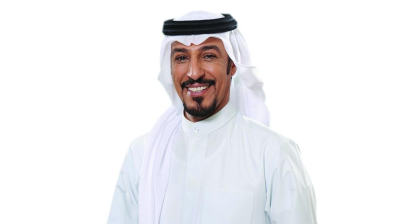

The background color is white
The background color is white
True


In [ ]:
#scaled = cv2.resize(frame, (224, 224), interpolation=cv2.INTER_AREA)

stat = crop_mask(frame, masks, boxes, labels, sizeim=(224, 224))
print(stat)